In [3]:
import json
import pandas as pd

# Load JSON
with open("../data/test_QA/forum.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(data)

# Inspect structure
df.head()


,content,url,title,collection,foundation,howto
0,"User: helpmeplease2023\nBody:\n[{""insert"":{""em...",https://forum.cogsci.nl/discussion/8343,Loading the packages of module jasp descriptiv...,forum,False,False
1,"User: kolfers\nBody:\n[{""insert"":""Hi all, \nI ...",https://forum.cogsci.nl/discussion/8344,losing focus during longer sleeps or slide dur...,forum,False,False
2,"User: SMD1990\nBody:\n[{""insert"":""Hi, \nI was ...",https://forum.cogsci.nl/discussion/8345,Testing Null Hypothesis in Bayesian Linear Mix...,forum,False,False
3,"User: Farina\nBody:\n[{""insert"":""As I am curre...",https://forum.cogsci.nl/discussion/8346,Custom Contrasts in JASP RM Anova: different d...,forum,False,False
4,"User: MikJ\nBody:\n[{""insert"":""Hi,\nI posted t...",https://forum.cogsci.nl/discussion/8348,Bayesian repeated measures ANOVA - Model Compa...,forum,False,False


In [5]:
df["text"] = df["title"].fillna('') + " " + df["content"].fillna('')


[nltk_data] Downloading package stopwords to /Users/ywxiu/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


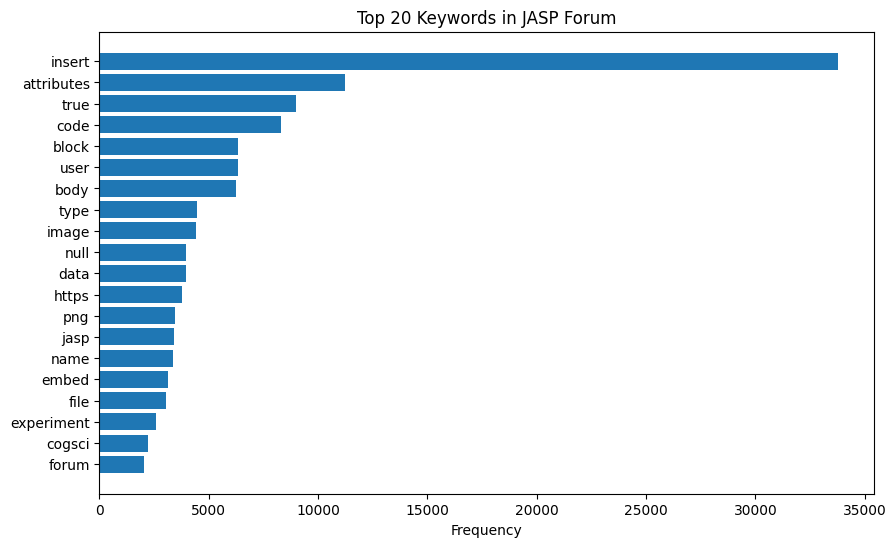

In [ ]:
from collections import Counter
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# Tokenize and clean
def tokenize(text):
    words = re.findall(r'\b[a-z]{3,}\b', text.lower())
    return [w for w in words if w not in stop_words]


all_words = [word for text in df["text"] for word in tokenize(text)]
counter = Counter(all_words)
most_common = counter.most_common(20)

# Plot top 20 keywords
words, counts = zip(*most_common)
plt.figure(figsize=(10,6))
plt.barh(words[::-1], counts[::-1])
plt.title("Top 20 Keywords in JASP Forum")
plt.xlabel("Frequency")
plt.show()


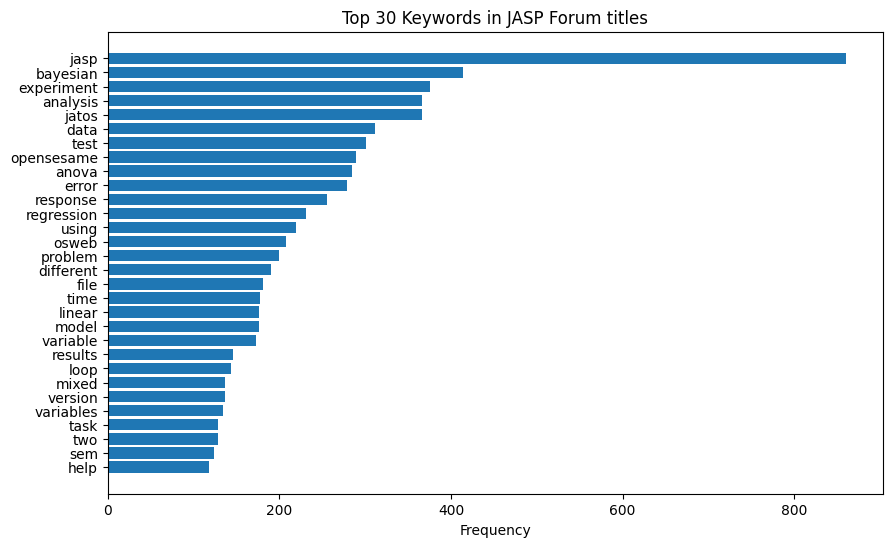

In [16]:
all_words = [word for text in df["title"] for word in tokenize(text)]
counter = Counter(all_words)
most_common = counter.most_common(30)

# Plot top 20 keywords
words, counts = zip(*most_common)
plt.figure(figsize=(10,6))
plt.barh(words[::-1], counts[::-1])
plt.title("Top 30 Keywords in JASP Forum titles")
plt.xlabel("Frequency")
plt.show()

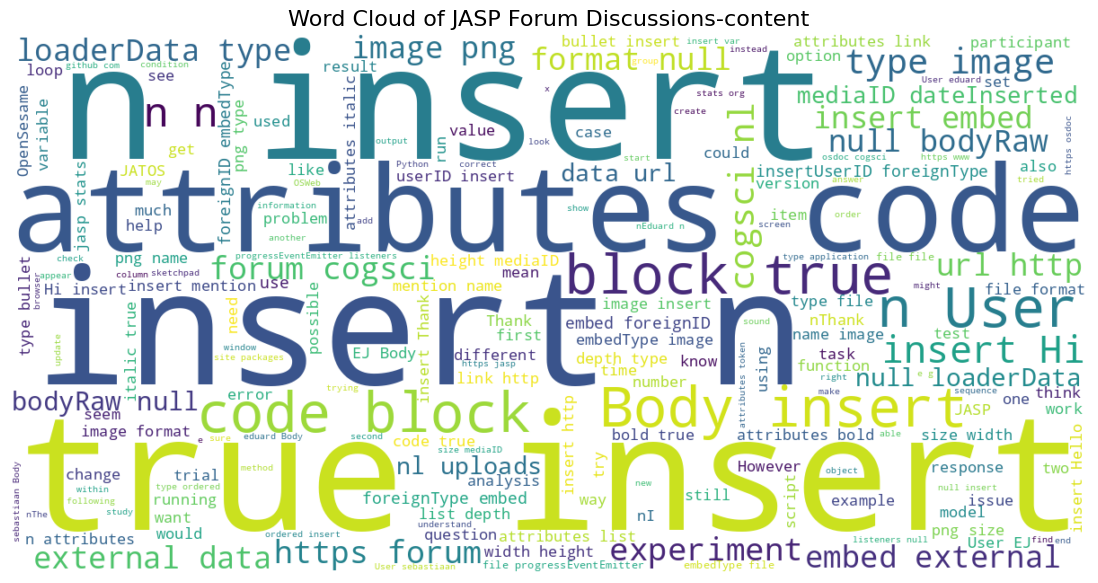

In [12]:
from wordcloud import WordCloud

text_all = " ".join(df["content"].dropna().tolist())
wc = WordCloud(width=1200, height=600, background_color="white", stopwords=stop_words).generate(text_all)

plt.figure(figsize=(15,7))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of JASP Forum Discussions-content", fontsize=16)
plt.show()


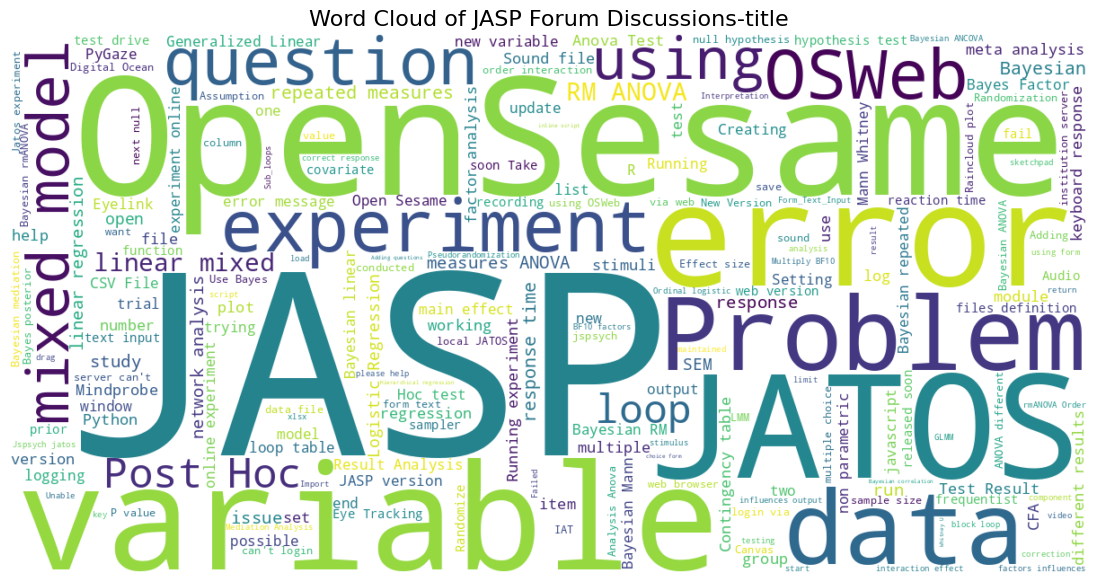

In [10]:
from wordcloud import WordCloud

text_all = " ".join(df["title"].dropna().tolist())
wc = WordCloud(width=1200, height=600, background_color="white", stopwords=stop_words).generate(text_all)

plt.figure(figsize=(15,7))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of JASP Forum Discussions-title", fontsize=16)
plt.show()


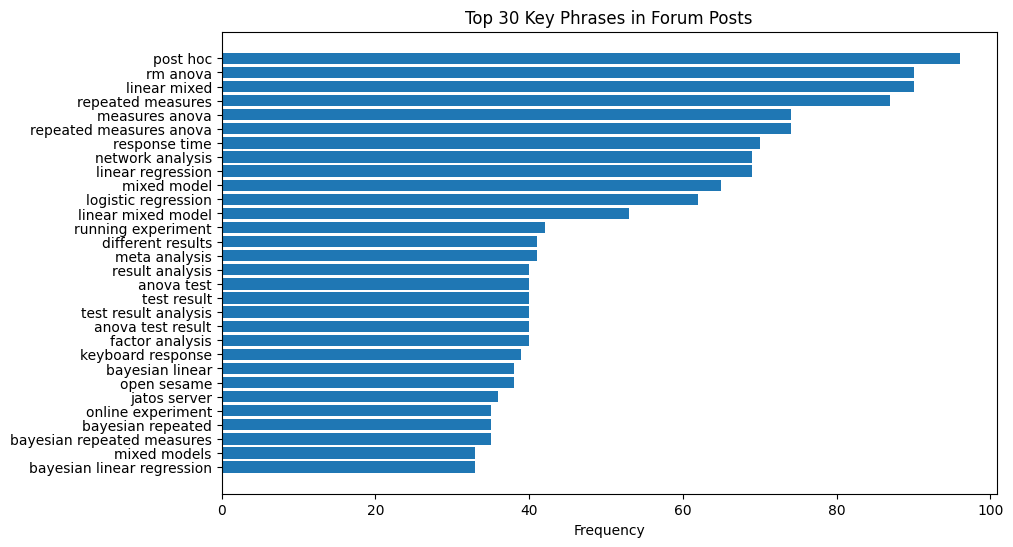

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(2,3), stop_words='english', max_features=50)
X = vectorizer.fit_transform(df["title"])
phrases = vectorizer.get_feature_names_out()
counts = X.toarray().sum(axis=0)

phr_df = pd.DataFrame({'phrase': phrases, 'count': counts})
phr_df = phr_df.sort_values(by='count', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(phr_df['phrase'].head(30)[::-1], phr_df['count'].head(30)[::-1])
plt.title("Top 30 Key Phrases in Forum Posts")
plt.xlabel("Frequency")
plt.show()


## cleaned co-occurrence data into a network graph

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(df["title"])

kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

df.groupby('cluster')['text'].apply(lambda x: ' '.join(x)[:500])


cluster
0    losing focus during longer sleeps or slide dur...
1    JATOS not starting up User: m.vel\nBody:\n[{"i...
2    OSWeb error: Unexpected token. Possible form i...
3    Raincloud plots - paired t-test visualisation ...
4    Loading the packages of module jasp descriptiv...
Name: text, dtype: object

In [24]:
import numpy as np

terms = vectorizer.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

for i in range(5):
    print(f"\n--- Cluster {i} ---")
    top_terms = [terms[ind] for ind in order_centroids[i, :10]]
    print("Top keywords:", ", ".join(top_terms))



--- Cluster 0 ---
Top keywords: experiment, response, bayesian, analysis, data, error, time, anova, problem, regression

--- Cluster 1 ---
Top keywords: jatos, server, experiment, jspsych, study, local, run, browser, login, institution

--- Cluster 2 ---
Top keywords: opensesame, osweb, file, variables, using, error, log, released, logging, drive

--- Cluster 3 ---
Top keywords: test, result, anova, analysis, bayesian, prior, hypothesis, whitney, mann, null

--- Cluster 4 ---
Top keywords: jasp, new, different, analysis, bayesian, regression, mixed, results, variable, sem


In [37]:


import re
from itertools import combinations
from collections import Counter
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Add custom domain stopwords
custom_stop = {"jasp", "help", "problem", "issue", "question", "using", "please"}
stop_words = stop_words.union(custom_stop)

tokens = [
    [w for w in re.findall(r'\b[a-z]{3,}\b', t.lower()) if w not in stop_words]
    for t in df["title"]
]

pairs = [tuple(sorted(c)) for toks in tokens for c in combinations(set(toks), 2)]
pair_counts = Counter(pairs)


# Top 20 co-occurring word pairs
for pair, count in pair_counts.most_common(20):
    print(f"{pair}: {count}")


('anova', 'bayesian'): 104
('hoc', 'post'): 96
('linear', 'mixed'): 90
('measures', 'repeated'): 87
('mixed', 'model'): 82
('anova', 'repeated'): 81
('jatos', 'server'): 80
('anova', 'measures'): 79
('linear', 'regression'): 72
('linear', 'model'): 70
('response', 'time'): 70
('analysis', 'network'): 69
('different', 'results'): 63
('experiment', 'online'): 63
('logistic', 'regression'): 62
('bayesian', 'test'): 61
('analysis', 'bayesian'): 56
('analysis', 'anova'): 55
('anova', 'test'): 54
('bayesian', 'regression'): 49


[nltk_data] Downloading package stopwords to /Users/ywxiu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [53]:
import pandas as pd

pair_df = pd.DataFrame(pair_counts.items(), columns=['pair', 'count'])
pair_df = pair_df.sort_values(by='count', ascending=False)
pair_df.head(50)


,pair,count
80,"(anova, bayesian)",104
227,"(hoc, post)",96
50,"(linear, mixed)",90
78,"(measures, repeated)",87
49,"(mixed, model)",82
74,"(anova, repeated)",81
740,"(jatos, server)",80
88,"(anova, measures)",79
1139,"(linear, regression)",72
383,"(response, time)",70


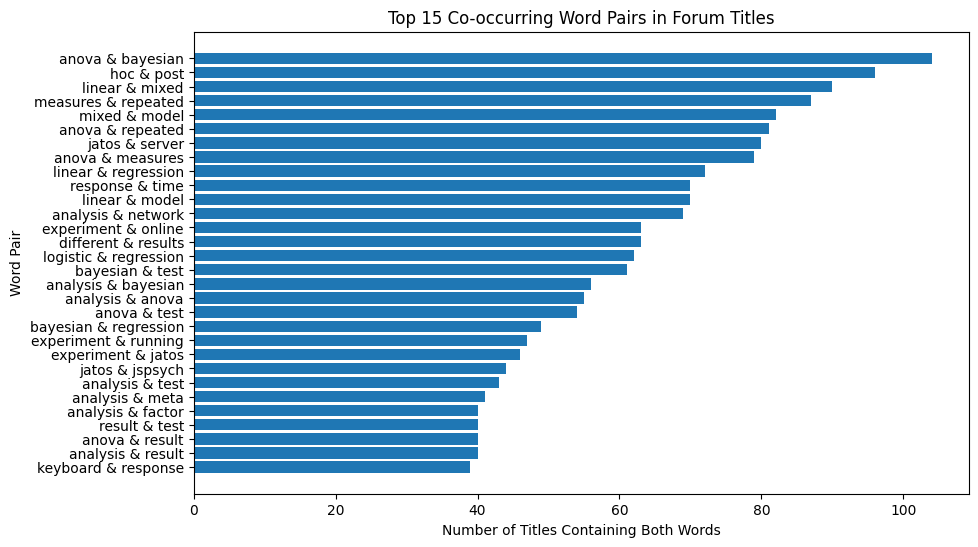

In [52]:
import matplotlib.pyplot as plt

top_pairs = pair_df.head(30)
plt.figure(figsize=(10,6))
plt.barh([' & '.join(p) for p in top_pairs['pair']], top_pairs['count'])
plt.xlabel("Number of Titles Containing Both Words")
plt.ylabel("Word Pair")
plt.title("Top 15 Co-occurring Word Pairs in Forum Titles")
plt.gca().invert_yaxis()
plt.show()


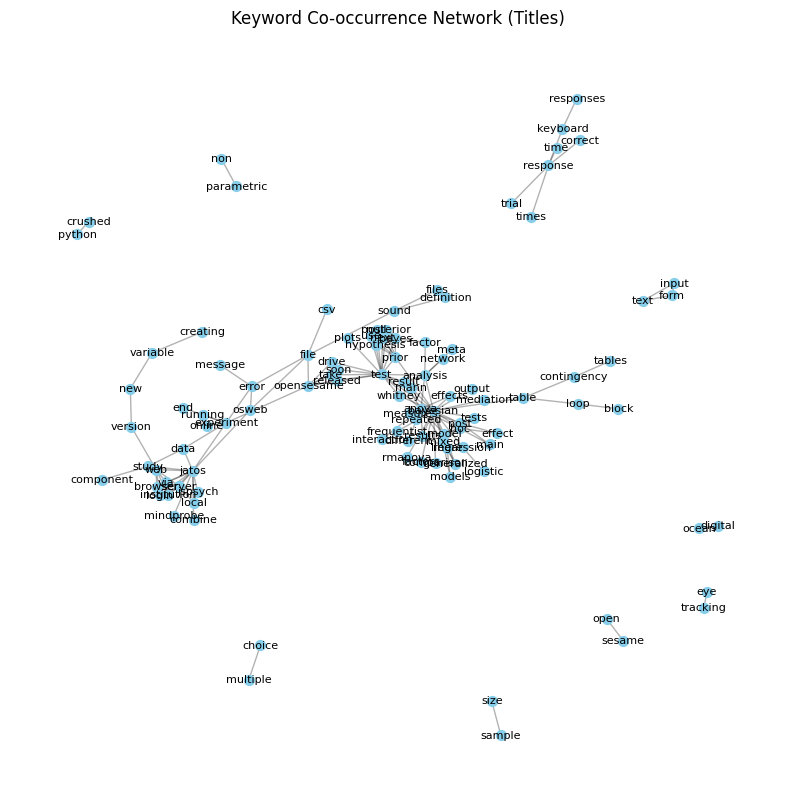

In [40]:
import networkx as nx

G = nx.Graph()
for (a, b), w in pair_counts.items():
    if w > 20:  # threshold to simplify the graph
        G.add_edge(a, b, weight=w)

plt.figure(figsize=(10,10))
pos = nx.spring_layout(G, k=0.4)
nx.draw_networkx_nodes(G, pos, node_size=50, node_color="skyblue")
nx.draw_networkx_edges(G, pos, alpha=0.3)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.title("Keyword Co-occurrence Network (Titles)")
plt.axis("off")
plt.show()
